1. Tecnica de Aprendizaje Automatizado: Para la tecnica de aprendizaje automatico se utilizo el modelo ElasticNet, este es mucho mas util que el modelo lineal, porque evita sobreajuestes, cuando hay variables de poca influencia o mucho ruido.

2. El mercado y los activos: En este caso, para tener varios activos en los cuales invertir, y adicionalmente que sean lo suficiente mente variados los unos de otros, se utiliza el mercado S&P500, y se utilizan todos los activos.
Tal como se muestra en la siguiente linea de codigo

In [ ]:
stock_data = qndata.stocks.load_spx_data()

3. Variables: En este caso se agrego la variable momentum, la cual es útil para capturar la tasa de cambio del precio de un activo en un periodo de tiempo determinado en este caso en especifico es por el periodo de los últimos 10 días



4. En la parte de los objetivos, para poder comprar, mantenerce o vender, se realizo tal como se puede ver en el siguiente codigo

In [ ]:
def get_target_classes(data, threshold=0.01):

    price_current = data.sel(field="close")
    price_future = qnta.shift(price_current, -1)

    # Calculate percentage change
    price_change = (price_future - price_current) / price_current

    # Define target classes based on the change
    target_price_up = xr.where(price_change > threshold, 1, 0)  # 1: Significant upward movement
    target_price_down = xr.where(price_change < -threshold, -1, 0)  # -1: Significant downward movement

    # Combine the upward and downward targets
    target_classes = target_price_up + target_price_down

    return target_classes

5. Activos liquidos: Para los activos liquidos, simplemente se modifico el codigo que el profesor puso de ejemplo, tal como se puede ver en el siguiente codigo

In [ ]:
open = stock_data.sel(field='open')
close = stock_data.sel(field='close')
high = stock_data.sel(field='high')
low = stock_data.sel(field='low')

is_liquid = stock_data.sel(field='is_liquid')
stock_data = stock_data*is_liquid

Grafica 1

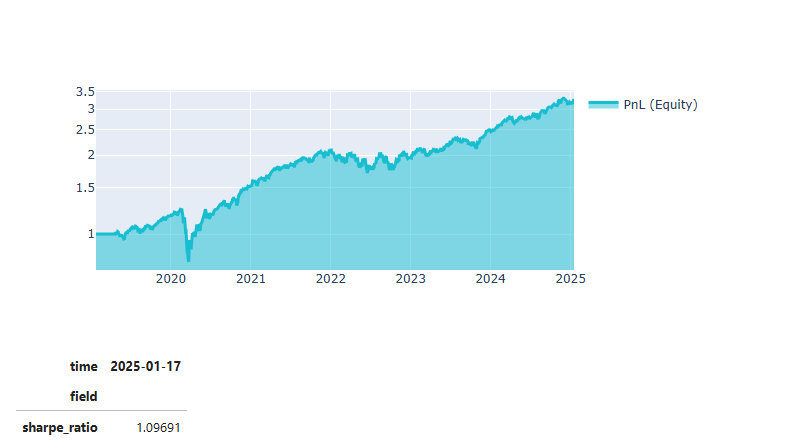

Grafica 2.
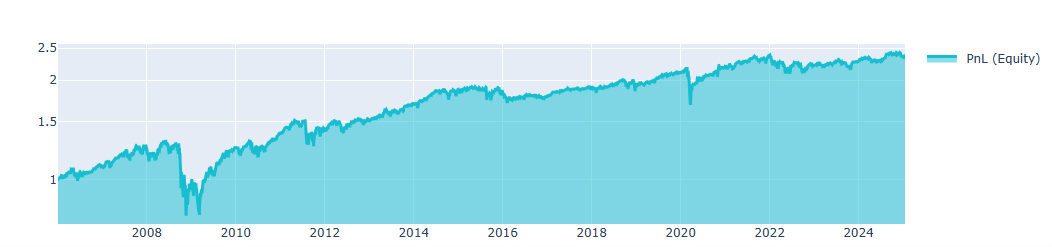

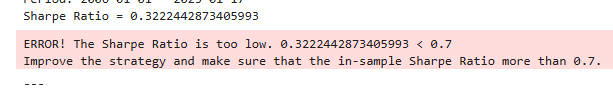